# Model Manager

This notebook shows how to:


1.   Train a NextStep-RNN on multiple time steps
2.   Use the ModelManager to make online predictions



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [3]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0
GPU support: True


In [0]:
# Load the data and unzip quietly
!wget -N https://pollithy.com/Pfeffer.zip
!unzip -q -u Pfeffer.zip

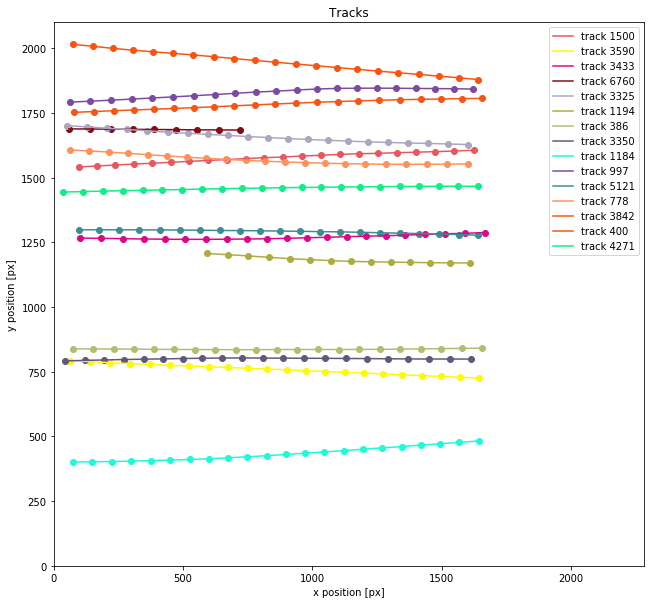

In [47]:
num_time_steps = 35
nan_value = 0
batch_size = 128


csv_data_set = data.CsvDataSet('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv',
                               timesteps=num_time_steps, nan_value=nan_value)

# get tf.Dataset for sequential training
dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

csv_data_set.plot_random_tracks(n=15)

In [48]:
# Train model

rnn_model, hash_ = model.rnn_model_factory(
        num_units_first_rnn=64, 
        num_units_second_rnn=1024,
        num_units_first_dense=64,
        rnn_model_name='gru',
        num_time_steps=num_time_steps, 
        batch_size=batch_size,
        nan_value=nan_value, 
        input_dim=2)
print(rnn_model.summary())

optimizer = tf.keras.optimizers.Adam()
train_step_fn = model.train_step_generator(rnn_model, optimizer)
calc_mae_test_fn = model.tf_error(rnn_model, dataset_test, csv_data_set.belt_width, squared=False)

loss_history = []
test_mae_history = []
total_num_epochs = 400

for epoch in range(total_num_epochs):
  # learning rate decay after 100 epochs
  if (epoch+1) % 150 == 0:
      old_lr = K.get_value(optimizer.lr)
      new_lr = old_lr * 0.1
      print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
      K.set_value(optimizer.lr, new_lr)

  for (batch_n, (inp, target)) in enumerate(dataset_train):
      _ = rnn_model.reset_states()
      loss = train_step_fn(inp, target)  
      loss_history.append(loss)
      

  if (epoch+1) % 50 == 0:
    test_mae_history.append(calc_mae_test_fn().numpy())

  print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (128, 35, 2)              0         
_________________________________________________________________
rnn-0 (GRU)                  (128, 35, 64)             13056     
_________________________________________________________________
rnn-1 (GRU)                  (128, 35, 1024)           3348480   
_________________________________________________________________
dense_17 (Dense)             (128, 35, 64)             65600     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (128, 35, 64)             0         
_________________________________________________________________
batch_normalization_5 (Batch (128, 35, 64)             256       
_________________________________________________________________
dense_18 (Dense)             (128, 35, 2)            

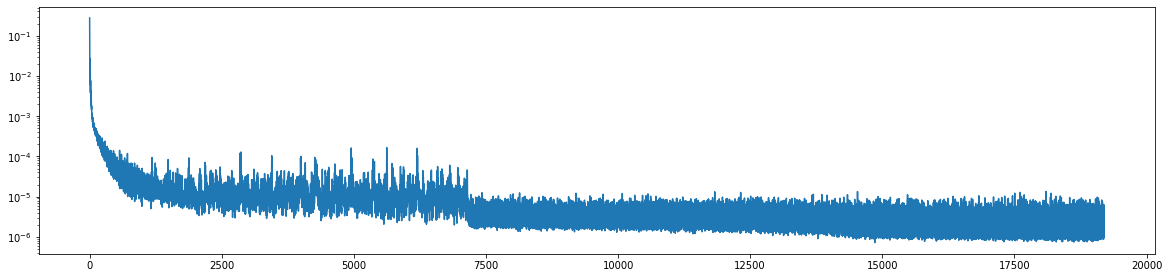

In [49]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale('log')
plt.plot(loss_history)

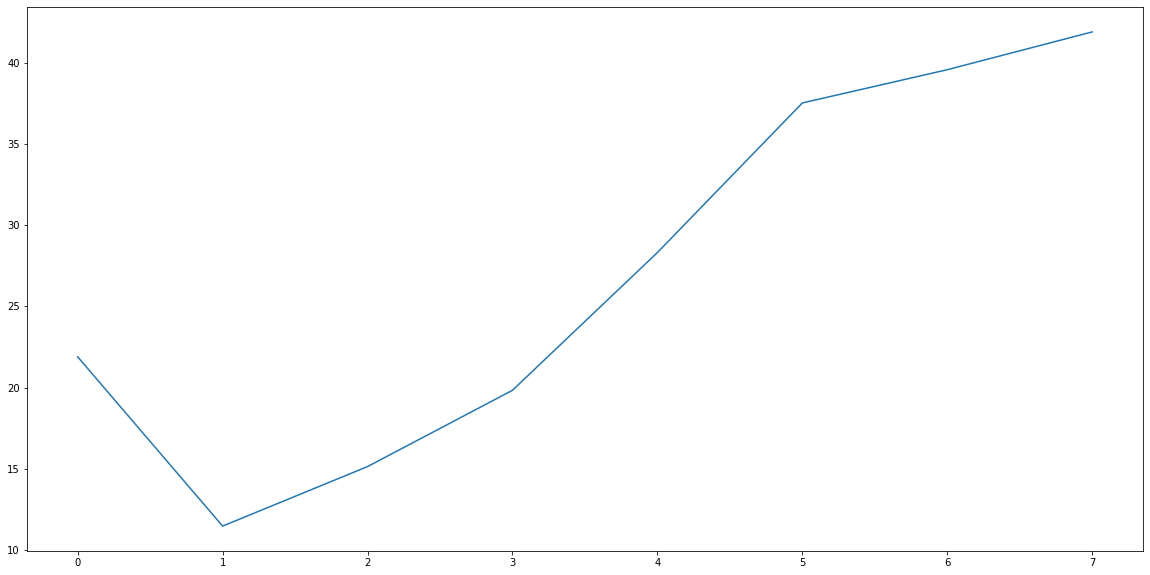

In [50]:
plt.plot(test_mae_history)